### 1. Data Preprocessing


[Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) - place csv file in /src/data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('./data/creditcard.csv')

In [2]:
from sklearn.model_selection import train_test_split


# stratified split
positive_cases = dataset[dataset['Class'] == 1]
negative_cases = dataset[dataset['Class'] == 0]

train_pos, test_pos = train_test_split(positive_cases, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(negative_cases, test_size=0.2, random_state=42)

train_pos_X, train_pos_y = train_pos.drop('Class', axis=1), train_pos['Class']
train_neg_X, train_neg_y = train_neg.drop('Class', axis=1), train_neg['Class']

test_pos_X, test_pos_y = test_pos.drop('Class', axis=1), test_pos['Class']
test_neg_X, test_neg_y = test_neg.drop('Class', axis=1), test_neg['Class']

train_X = pd.concat([train_pos_X, train_neg_X])
train_y = pd.concat([train_pos_y, train_neg_y])

test_X = pd.concat([test_pos_X, test_neg_X])
test_y = pd.concat([test_pos_y, test_neg_y])

### 2. Model Training

#### 2.1. Evaluation functions

In [3]:

import numpy as np
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

def recall(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
    return tp / (tp + fn)

def precision(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
    if tp + fp == 0:
        return 0
    return tp / (tp + fp)

def f1score(y_true, y_pred):
    rec = recall(y_true, y_pred)
    prec = precision(y_true, y_pred)
    return 2 * (rec * prec) / (rec + prec)

In [4]:
def calculate_roc_curve(y_true, y_scores):
    thresholds = np.sort(y_scores)
    tpr = []
    fpr = []
    
    for threshold in thresholds:
        # Classify based on the threshold
        predicted_class = (y_scores >= threshold).astype(int)
        
        # Calculate true positives, false positives, true negatives, false negatives
        tp = np.sum((predicted_class == 1) & (y_true == 1))
        fp = np.sum((predicted_class == 1) & (y_true == 0))
        tn = np.sum((predicted_class == 0) & (y_true == 0))
        fn = np.sum((predicted_class == 0) & (y_true == 1))
        
        # Calculate TPR and FPR
        tpr.append(tp / (tp + fn))  # Sensitivity, True Positive Rate
        fpr.append(fp / (fp + tn))  # 1 - Specificity, False Positive Rate
    
    return np.array(fpr), np.array(tpr), thresholds

def plot_roc(y_true, y_pred):
    points_x, points_y, thresholds = roc(y_true, y_pred)
    plt.plot(points_x, points_y)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    

#### 2.2 Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

linear_regression_model = LogisticRegression(max_iter=1000)
linear_regression_model.fit(train_X, train_y)

lr_predictions = linear_regression_model.predict_proba(test_X)[:, 1]
lr_predictions_binary = (lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, lr_predictions_binary)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.64      0.72        99

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2.3 Random Forest

In [8]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=3)
random_forest_model.fit(train_X, train_y)

rf_predictions = random_forest_model.predict_proba(test_X)[:, 1]
rf_predictions_binary = (rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.84      0.57      0.67        99

    accuracy                           1.00     56962
   macro avg       0.92      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



#### 2.4 KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(train_X, train_y)

knn_predictions = knn_model.predict_proba(test_X)[:, 1]
knn_predictions_binary = (knn_predictions >= 0.5).astype(int)

print(classification_report(test_y, knn_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.28      0.21      0.24        99

    accuracy                           1.00     56962
   macro avg       0.64      0.61      0.62     56962
weighted avg       1.00      1.00      1.00     56962



#### 2.5 XGBoost

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5)
xgb_model.fit(train_X, train_y)

xgb_predictions = xgb_model.predict_proba(test_X)[:, 1]
xgb_predictions_binary = (xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, xgb_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### 3. Model Evaluation

In [21]:
models = {"Logistic Regression": linear_regression_model,
          "Random Forest": random_forest_model, 
          "KNN": knn_model, 
          "XGBoost": xgb_model}

predictions = {"Logistic Regression": lr_predictions,
                "Random Forest": rf_predictions,
                "KNN": knn_predictions,
                "XGBoost": xgb_predictions}

dir_name = {"Logistic Regression": "LR",
            "Random Forest": "RF",
            "KNN": "KNN",
            "XGBoost": "XGB"}

#### 3.1. ROC Curve

Logistic Regression
Random Forest
KNN
XGBoost


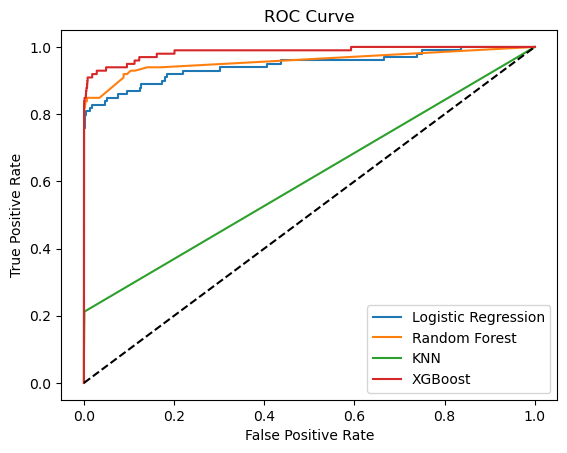

In [22]:
from sklearn.metrics import roc_curve

for name, model in models.items():
    print(name)
    fpr, tpr, thresholds = roc_curve(test_y, predictions[name])
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('./plots/roc_curve.png')
plt.show()

#### 3.2. Confusion Matrix

Logistic Regression
[[56849    14]
 [   36    63]]


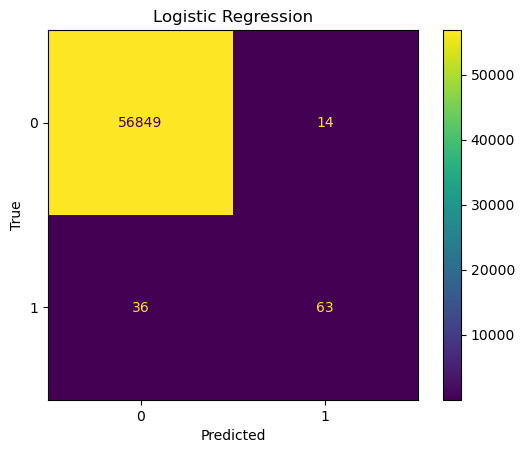

Random Forest
[[56852    11]
 [   43    56]]


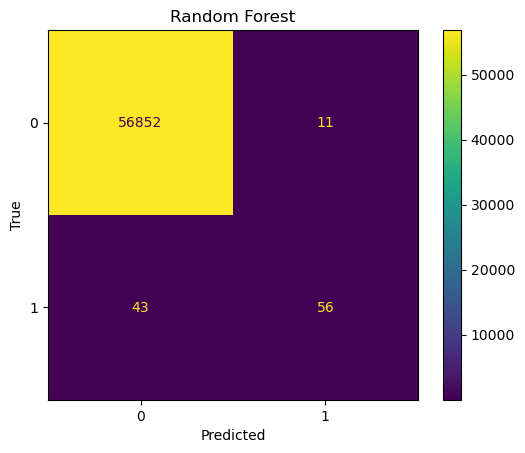

KNN
[[56808    55]
 [   78    21]]


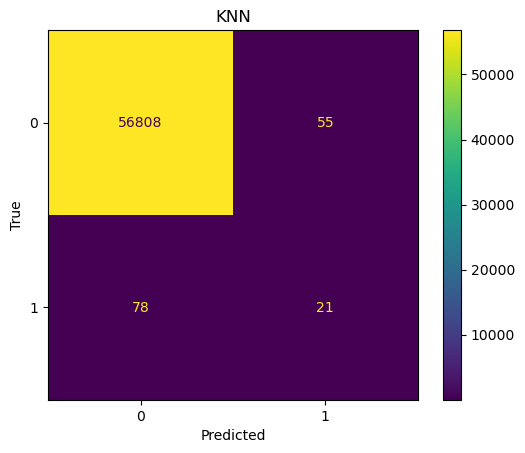

XGBoost
[[56857     6]
 [   22    77]]


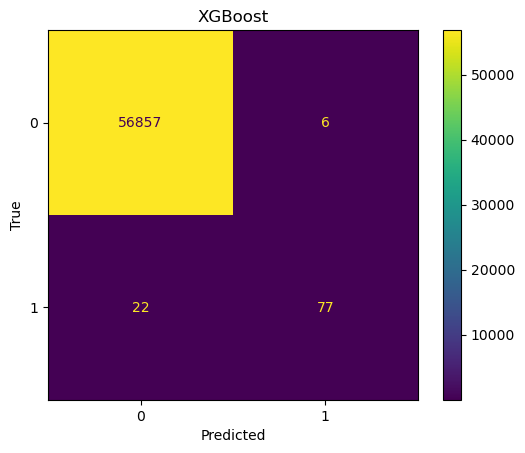

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from seaborn import heatmap

for name, model in models.items():
    print(name)
    print(confusion_matrix(test_y, (predictions[name] >= 0.5).astype(int)))
    
    cm = confusion_matrix(test_y, (predictions[name] >= 0.5).astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(name)
    plt.savefig(f'./plots/{dir_name[name]}/confusion_matrix.png')
    plt.show()
    